In [77]:
%matplotlib inline

import cv2
import numpy as np
import copy
from matplotlib import pyplot as plt
import matplotlib.cm as cm

When I started this project I really had multiple goals in mind.  I know that being able to automate nematode 
assays could be extremely useful both for individual pathology labs as well as the larger NCDA Soil samples.  
Successful automation means the program can count worms in a photo, classify them, and remove any debris.  None of this will be done perfectly by a computer, so leaving a methodolgy open for trained personnel to correct the analysis is important.  

To begin I started with a quick google search for nematode slides.  I've worked with microscope assays before  both as a graduate and undergraduate.  A good slide should be sufficiently diluted that it is possible to actually count worms (There will be some overlapping worms, but the majority should be seperated). 

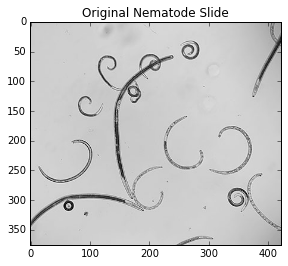

In [57]:
# Reads in the files
filename = '/Users/lehassell/PycharmProjects/nematode/nems.jpg'
original = cv2.imread('nems.jpg', 0)
img = copy.deepcopy(original)
plt.imshow(original, cmap=cm.Greys_r)
plt.title('Original Nematode Slide')
plt.show()

Now with a sample image I need to begin the process of extracting meaningful information.  As I recall most nematode assays are done with only the microscope backlight on (this means they are grey scale).  I will start by 
removing noise from the image and select out the foreground.  

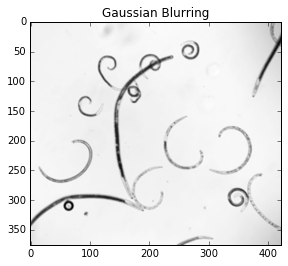

In [67]:
blurred = cv2.GaussianBlur(img, (5, 5), 0)
thresh, th1 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(blurred, cmap=cm.Greys_r)
plt.title('Gaussian Blurring')
plt.show()

I ran multiple commands in the last block and this demonstrates the first of them.  I applied a Gaussian blurr to smooth out the image.  This removes jagged edges and any small pieces of debris (things smaller than a few     pixels).

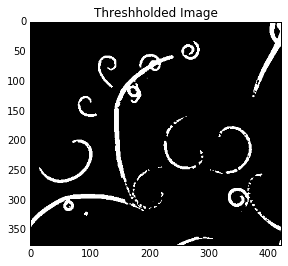

In [68]:
plt.imshow(th1, cmap=cm.Greys_r)
plt.title('Threshholded Image')
plt.show()

This next image shows what happens after I applied a thresholding algorithm.  The goal here was to highlight the pixels that were 'brighter' than the background.  The method used here is called the otsu threshold that essentially takes the distribution of pixel brightness frequencies and creates two classes that minimize intra-class variance.  

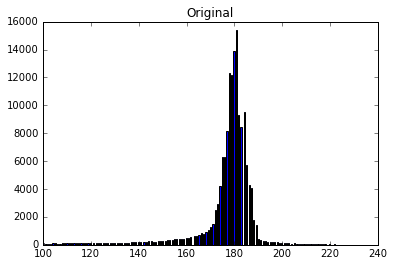

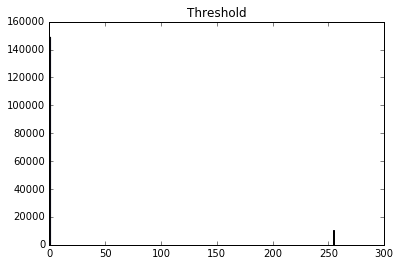

In [26]:
plt.hist(original.ravel(),256,[100,225])
plt.title('Original')
plt.show()

plt.hist(th1.ravel(), 256)
plt.title('Threshold')
plt.show()

At this point I should be ready to have my program find the contours of polygons in the image.  The program will pick anything in the foreground (the white) and note the bounds.  

In [63]:
image, contours, hierarchy = cv2.findContours(th1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_1 = copy.deepcopy(original)
img_2 = copy.deepcopy(original)
print(len(contours))

62


So the print line tells me how many total contours the program has detected - 62.  That seems a bit high, lets visualize the contours by putting a minimum bounding circle around each object.

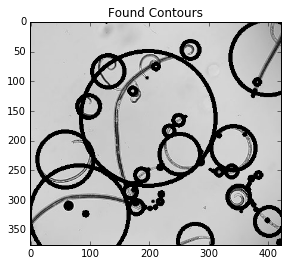

In [61]:
for cnt in contours:
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        circle_image = cv2.circle(img_1, center, radius, (0, 255, 0), 5)

plt.imshow(circle_image, cmap=cm.Greys_r)
plt.title('Found Contours')
plt.show()

It definitely seems to be finding objects.  However there are a lot of little circles for objects we aren't concerned with.  Lets try setting only minimum radii.

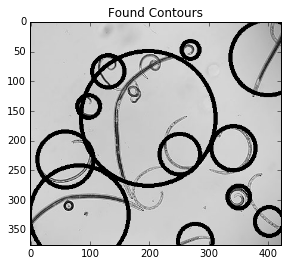

In [88]:
for cnt2 in contours:
        (x, y), radius = cv2.minEnclosingCircle(cnt2)
        center = (int(x), int(y))
        radius = int(radius)
        if radius > 12:
            circle_image_2 = cv2.circle(img_2, center, radius, (0, 255, 0), 5)

plt.imshow(circle_image_2, cmap=cm.Greys_r)
plt.title('Found Contours')
plt.show()

By limiting the size of the radius, we were able to help focus where the program looks.  If all we wanted to do is count nematodes then this is probably not a bad place to get the model to.  The user can simply add missing worms to the tally with a quick visual assessment.

For the next step of seperating out nematode species and debris, it'd be better if we made sure everything was fully in a target circle.  How can we improve this?  One method is to go back to the thresholding and re-examine the contours it is calculating.

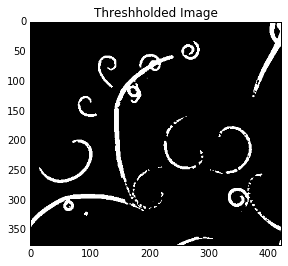

In [69]:
plt.imshow(th1, cmap=cm.Greys_r)
plt.title('Threshholded Image')
plt.show()

I suspect the main source of so many tiny circles is due to fragmentation of the shapes during thresholding.  The nematodes are not uniformly consistant throughout their bodies and this causes some of the pixels to be lost.  One way we can counter this is by eroding and filling in the shapes.

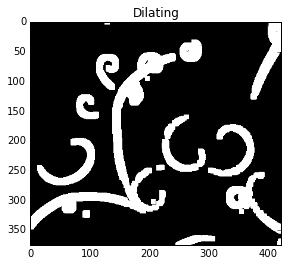

In [89]:
kernel = np.ones((8,8), np.uint8)
dilation = cv2.dilate(th1, kernel, iterations=1)
plt.imshow(dilation, cmap=cm.Greys_r)
plt.title('Dilating')
plt.show()

Dilation is a process that is somewhat similar to smoothing.  This process takes a kernel and paints it over my binary (thresholded) image.  This helps close the gaps within the worms, but also expands their contours.  This means that if I were to run a contour process now, many of the worms would be 'touching' and considered one object.  


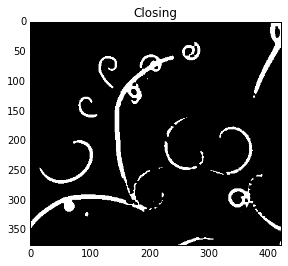

In [92]:
kernel_close = np.ones((4, 4), np.uint8)
closing = cv2.morphologyEx(th1, cv2.MORPH_CLOSE, kernel_close)
plt.imshow(closing, cmap=cm.Greys_r)
plt.title('Closing')
plt.show()

Closing checks the kernels for the number of pixels within an area, and if it is below a certain limit will simply erase all pixels.  This means that in the center of the nematode bodies where pixels are dense, it will have no effect.  On the outer edges it will help erode the edges, and hopefully keep different worms from connecting while not undoing our work.

In [93]:
image_closed, contours_closed, hierarchy_closed = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_3 = copy.deepcopy(original)
img_4 = copy.deepcopy(original)
print(len(contours_closed))

40


Still not quite perfect, but it did do a better job of removing the smaller fragments.  Lets visualize the objects.

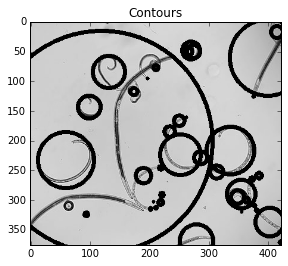

In [94]:
for cnt3 in contours_closed:
        (x, y), radius = cv2.minEnclosingCircle(cnt3)
        center = (int(x), int(y))
        radius = int(radius)
        circle_image_3 = cv2.circle(img_3, center, radius, (0, 255, 0), 5)

plt.imshow(circle_image_3, cmap=cm.Greys_r)
plt.title('Contours')
plt.show()

Now to revisit my earlier tactic of minimum radii.

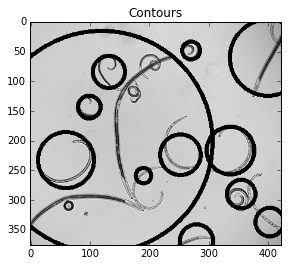

In [97]:
for cnt4 in contours_closed:
        (x, y), radius = cv2.minEnclosingCircle(cnt4)
        center = (int(x), int(y))
        radius = int(radius)
        if radius > 12:
            circle_image_4 = cv2.circle(img_4, center, radius, (0, 255, 0), 5)

plt.imshow(circle_image_4, cmap=cm.Greys_r)
plt.title('Contours')
plt.show()

At this stage, most everything is at least in a circle and with the circle better covering the full nematode.  There are still some problems but at this stage Nematodes could be automatically cropped from the photos.
The next stage is to get more sample images and begin building a library of nematode images to train a model on.  
